In [46]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import os
import numpy as np
import time
from PIL import Image
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True
from collections import defaultdict
import cv2
import pdb
IMG_SIZE = (224,224)
import pandas as pd
from torchvision import models
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import torch
from skimage import io, transform
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.utils.data as data_utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F 
import numpy as np


In [47]:
class Emotion_Dataset(Dataset):
    """Emotion dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.data_frame.iloc[idx, 22],
                                self.data_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        image = Image.open(img_name)
        image = image.convert('RGB')
        #tr = transforms.ToTensor()
        #image = tr(image)
        #landmarks = self.data_frame.iloc[idx, 21]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        emotion = self.data_frame.iloc[idx,21]
        emotion = np.array([emotion])
        emotion = emotion.astype('int').reshape((1))
        
        sample = {'image': image, 'emotion': emotion}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample
    

In [48]:
def show_emotion_audio(image, emotion):
    """Show image with landmarks"""
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.title(emotion)
    plt.pause(0.001)  # pause a bit so that plots are updated

0 <PIL.Image.Image image mode=RGB size=400x300 at 0x7F0DBB195E50> (1,)


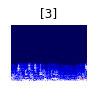

1 <PIL.Image.Image image mode=RGB size=400x300 at 0x7F0DBB0C6AD0> (1,)


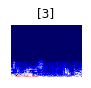

2 <PIL.Image.Image image mode=RGB size=400x300 at 0x7F0DBB0CDFD0> (1,)


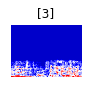

3 <PIL.Image.Image image mode=RGB size=400x300 at 0x7F0DBB087FD0> (1,)


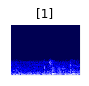

In [49]:
root_dir = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/cb_removed/without_noise_cleanup/"
emotion_dataset = Emotion_Dataset(csv_file=root_dir + 'input_data.csv',
                                    root_dir=root_dir)

fig = plt.figure()

for i in range(len(emotion_dataset)):
    sample = emotion_dataset[i]

    print(i, sample['image'], sample['emotion'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_emotion_audio(**sample)

    if i == 3:
        plt.show()
        break


In [50]:
composed = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              
                              ])

In [51]:
class Img2RGB(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, emotion = sample['image'], sample['emotion']

        imgage = img.convert('RGB')
        return {'image': image, 'emotion': emotion}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [52]:
fig = plt.figure()
sample = emotion_dataset[65]
#print(sample)
'''
for i, tsfrm in enumerate([composed]):
    t_s = tsfrm(sample['image'])
    print(t_s.shape)
    transformed_sample["image"] = t_s
    transformed_sample['emotion'] = sample['emotion']
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_emotion_audio(**transformed_sample)

plt.show()
'''

'\nfor i, tsfrm in enumerate([composed]):\n    t_s = tsfrm(sample[\'image\'])\n    print(t_s.shape)\n    transformed_sample["image"] = t_s\n    transformed_sample[\'emotion\'] = sample[\'emotion\']\n    ax = plt.subplot(1, 3, i + 1)\n    plt.tight_layout()\n    ax.set_title(type(tsfrm).__name__)\n    show_emotion_audio(**transformed_sample)\n\nplt.show()\n'

<Figure size 432x288 with 0 Axes>

In [53]:

root_dir = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/cb_removed/without_noise_cleanup/"
emotion_dataset = Emotion_Dataset(csv_file=root_dir + 'input_data.csv',
                                    root_dir=root_dir, transform=composed)

In [54]:
for i in range(len(emotion_dataset)):
    sample = emotion_dataset[i]

    print(i, sample['image'].shape, sample['emotion'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) [3]
1 torch.Size([3, 224, 224]) [3]
2 torch.Size([3, 224, 224]) [3]
3 torch.Size([3, 224, 224]) [1]


In [55]:
total_images = len(emotion_dataset)
test_data_images = np.int(total_images*0.2)
train_data_images = total_images - test_data_images
print("Train image count",train_data_images)
print("Test image count",test_data_images)
loader_train = DataLoader(emotion_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0,train_data_images)))

loader_val = DataLoader(emotion_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(train_data_images, train_data_images+test_data_images)))


Train image count 6338
Test image count 1584


In [56]:
for t, x in enumerate(loader_val):
    print(t, x['image'].shape, x['emotion'].shape)
    #print(x,y)
    if t == 3:
        break
    

0 torch.Size([64, 3, 224, 224]) torch.Size([64, 1])
1 torch.Size([64, 3, 224, 224]) torch.Size([64, 1])
2 torch.Size([64, 3, 224, 224]) torch.Size([64, 1])
3 torch.Size([64, 3, 224, 224]) torch.Size([64, 1])


In [57]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [58]:
print_every = 1

In [59]:
def check_train_accuracy11(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on TRAIN set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for da in loader:
            #pdb.set_trace()
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            x = da['image']
            y = da['emotion']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc


def check_train_accuracy(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on TRAIN set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            #pdb.set_trace()
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
    
def check_accuracy_part34(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on VAL set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for da in loader:
            #pdb.set_trace()
            x = da['image']
            y = da['emotion']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
    
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    acc = 0
    per_epoch_train_accuracy_list = []
    per_epoch_test_accuracy_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    loss_list = []
    best_model = model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, da in enumerate(loader_train):
            #import pdb
            #pdb.set_trace()
            model.train()  # put model to training mode
            x = da['image']
            y = da['emotion']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            loss_list.append(loss.item())
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            #pdb.set_trace()
            #print("IN ITERATION", t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #pdb.set_trace()
                xx = x.cpu().data.numpy()
                yy = y.cpu().data.numpy()
                tt_data = []
                for i in range(len(xx)):
                  #ind = np.where(keys_array==Y[i]) 
                  tt_data.append([xx[i], yy[i]])
                
                train_d = DataLoader(tt_data, batch_size = 1)
                
                train_acc = check_train_accuracy(train_d, model)
                train_accuracy_list.append(train_acc)
                test_acc = check_accuracy_part34(loader_val, model)
                test_accuracy_list.append(test_acc)
                if test_acc > acc:
                  acc = test_acc
                  best_model = copy.deepcopy(model)
                print()
        
        e_test_accuracy = check_accuracy_part34(loader_val, model)        
        per_epoch_test_accuracy_list.append(e_test_accuracy)     
        e_train_accuracy = check_train_accuracy11(loader_train, model)        
        per_epoch_train_accuracy_list.append(e_train_accuracy)     
    return best_model, acc, train_accuracy_list, test_accuracy_list, per_epoch_train_accuracy_list, per_epoch_test_accuracy_list, loss_list 

In [ ]:
class Flatten(nn.Module):
    def flatten(x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = nn.LSTM(input_size=(32*25*37),hidden_size=128,num_layers=2,batch_first=True,bidirectional =True, dropout=0.1)
        self.model = nn.RNN(input_size=(32*25*37),hidden_size=128,num_layers=2,batch_first=True,bidirectional =True, dropout=0.1)
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.unsqueeze(1)
       
        # Data is fed to the LSTM
        out, _ = self.model(x)

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.squeeze(1)


        return out

#hidden_layer_size = 500
#learning_rate = 1e-2

#model = nn.Sequential(
#    Flatten(),
#    nn.Linear(3 * 200 * 300, hidden_layer_size),
#    nn.ReLU(),
#    nn.Linear(hidden_layer_size, keys_array.shape[0]),
#)


l1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(12,16), padding=(6,8), stride=1),
            nn.ReLU(),
            #nn.Conv2d(channel_1, channel_1, kernel_size=5, padding=2, stride=1),
            nn.MaxPool2d(2, 2)
)
'''
for t, (x, y) in enumerate(loader_train):
            # put model to training mode
            x = x.to(device=device, dtype=dtype)
            import pdb
            pdb.set_trace()
            break
    
pdb.set_trace()
h = l1(x)
h.shape
'''

l2 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=(8,12), padding=(4,6), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
)
#h = l2(h)

l3 = nn.Sequential(
            nn.Conv2d(24, 32, kernel_size=(5,7), padding=(2,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Flatten(),
            LSTM()
            
)

#l4 = nn.Sequential(
#            nn.Conv2d(channel_3, channel_4, kernel_size=3, padding=1, stride=1),
#            nn.MaxPool2d(2, 1)
#)

#import pdb
#pdb.set_trace()
hidden_layer_size = 4
learning_rate = 1e-4 #1e-4   1e-3 looks gud
'''
model = nn.Sequential(
            l1,
            l2,
            l3,
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 4)
)
'''

#*****************************************************
###Transfer learning
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

#criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, 
                     betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #weight_decay = 0 luks gud. Trying with 0.1

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

best_model, best_test_acc, train_accuracy_list, test_accuracy_list, per_epoch_train_accuracy_list, per_epoch_test_accuracy_list, loss_list = train_part34(model, optimizer, 10)
#*****************************************************


# you can use Nesterov momentum in optim.SGD
#optimizer = optim.Adam(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, 
#                     betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #weight_decay = 0 luks gud. Trying with 0.1


#best_model, best_test_acc, train_accuracy_list, test_accuracy_list, loss_list = train_part34(model, optimizer, 2)
#best_model, best_test_acc, train_accuracy_list, test_accuracy_list, per_epoch_train_accuracy_list, per_epoch_test_accuracy_list, loss_list = train_part34(model, optimizer, 10)
print("DONE TRAINING")


Epoch 0, Iteration 0, loss = 1.4889
Checking accuracy on TRAIN set
Got 23 / 64 correct (35.94)
Checking accuracy on VAL set
Got 85 / 1584 correct (5.37)

Epoch 0, Iteration 1, loss = 1.4693
Checking accuracy on TRAIN set
Got 22 / 64 correct (34.38)
Checking accuracy on VAL set
Got 83 / 1584 correct (5.24)

Epoch 0, Iteration 2, loss = 1.5651
Checking accuracy on TRAIN set
Got 18 / 64 correct (28.12)
Checking accuracy on VAL set
Got 76 / 1584 correct (4.80)

Epoch 0, Iteration 3, loss = 1.5271
Checking accuracy on TRAIN set
Got 17 / 64 correct (26.56)
Checking accuracy on VAL set
Got 48 / 1584 correct (3.03)

Epoch 0, Iteration 4, loss = 1.5099
Checking accuracy on TRAIN set
Got 19 / 64 correct (29.69)
Checking accuracy on VAL set
Got 43 / 1584 correct (2.71)

Epoch 0, Iteration 5, loss = 1.4623
Checking accuracy on TRAIN set
Got 16 / 64 correct (25.00)
Checking accuracy on VAL set
Got 44 / 1584 correct (2.78)

Epoch 0, Iteration 6, loss = 1.4760
Checking accuracy on TRAIN set
Got 15 / 

In [ ]:
torch.save(best_model, "best_model_TFL_RNN_without_noise_cleanup_3sec_Time_Scale_50_epochs")
torch.save(model, "model_TFL_RNN_without_noise_cleanup_3sec_Time_scale_50_epochs")

##PLOT LOSS, TRAIN ACCURACY, TEST ACCURACY
import matplotlib.pyplot as plt
max_train_accuracy = np.repeat(np.max(np.array([train_accuracy_list])),   len(train_accuracy_list))

max_test_accuracy = np.repeat(np.max(np.array([test_accuracy_list])),   len(test_accuracy_list))

max_p_e_train_accuracy = np.repeat(np.max(np.array([per_epoch_train_accuracy_list])),   len(per_epoch_train_accuracy_list))

max_p_e_test_accuracy = np.repeat(np.max(np.array([per_epoch_test_accuracy_list])),   len(per_epoch_test_accuracy_list))

# plot the loss history
plt.subplot()
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.legend()
plt.show()

plt.subplot()
plt.plot(train_accuracy_list, label='train')
plt.plot(test_accuracy_list, label='val')
plt.plot(max_train_accuracy, label='max train acc')
plt.plot(max_test_accuracy, label='max val acc')
plt.title('Classification accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

plt.subplot()
plt.plot(per_epoch_train_accuracy_list, label='train')
plt.plot(per_epoch_test_accuracy_list, label='val')
plt.plot(max_p_e_train_accuracy, label='max train acc')
plt.plot(max_p_e_test_accuracy, label='max val acc')
plt.title('Per Epoch Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()



from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    #plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def check_train_accuracy1(loader, model, for_confusion_matrix=0):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on TRAIN set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    true_label_list = []
    predicted_label_list = []
    with torch.no_grad():
        for da in loader:
            x = da['image']
            y = da['emotion']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            #pdb.set_trace()
            true_label_list.append(y.cpu().data.numpy())
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x)
            _, preds = scores.max(1)
            predicted_label_list.append(preds.cpu().data.numpy())            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if for_confusion_matrix == 1:
          return acc, true_label_list, predicted_label_list
        else:
          return acc
    
    


In [ ]:
#best_model1 = torch.load("model2")
accuracy, true_label, predicted_label = check_train_accuracy1(loader_train, best_model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)

emotion_dict = ('hap',
                'sad',
                'ang',
                'neu'
                )
cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, emotion_dict)

In [ ]:
#best_model1 = torch.load("model1")
accuracy, true_label, predicted_label = check_train_accuracy1(loader_val, best_model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)


cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, emotion_dict)

In [ ]:
accuracy, true_label, predicted_label = check_train_accuracy1(loader_train, model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)

emotion_dict = ('hap',
                'sad',
                'ang',
                'neu'
                )
cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(10,6))
plot_confusion_matrix(cm, emotion_dict)

In [ ]:
#best_model1 = torch.load("model1")
accuracy, true_label, predicted_label = check_train_accuracy1(loader_val, model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)


cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(6,10))
plot_confusion_matrix(cm, emotion_dict)